In [1]:
print("🔗 Connexion à Google Drive...")
from google.colab import drive
drive.mount('/content/drive')
print("✅ Google Drive monté avec succès")

import os
from pathlib import Path

print("\n📁 Configuration des chemins de travail...")

# Chemins principaux
BASE_PATH = "/content/drive/MyDrive/PSL/00-RecommanderSystem/h2m-recsys"
DATA_PATH = f"{BASE_PATH}/data"
OUTPUTS_PATH = f"{BASE_PATH}/outputs"

🔗 Connexion à Google Drive...
Mounted at /content/drive
✅ Google Drive monté avec succès

📁 Configuration des chemins de travail...


In [2]:
!pip install git+https://github.com/daviddavo/lightfm

  Cloning https://github.com/daviddavo/lightfm to /tmp/pip-req-build-sgtrazr0
  Running command git clone --filter=blob:none --quiet https://github.com/daviddavo/lightfm /tmp/pip-req-build-sgtrazr0
  Resolved https://github.com/daviddavo/lightfm to commit f0eb500ead54ab65eb8e1b3890337a7223a35114
  Preparing metadata (setup.py) ... done
  Created wheel for lightfm: filename=lightfm-1.17-cp312-cp312-linux_x86_64.whl size=1100852 sha256=f0ff6954e0dcab4bfa90a747a8028860c53b596e02b7d320c9e788f487c6889c
  Stored in directory: /tmp/pip-ephem-wheel-cache-psxo_dca/wheels/fd/89/93/70c1e5f378ee5043de89387ee3ef6852ff39e3b9eb44ecc1a3
Successfully built lightfm


# ⚙️ Optimisation des Hyperparamètres
**Objectif :** Améliorer performances via hyperparameter tuning
- Grid search systématique
- Validation croisée temporelle
- Sélection configuration optimale

---

## 📁 CHARGEMENT ET SETUP


In [ ]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from lightfm import LightFM
from lightfm.evaluation import precision_at_k, recall_at_k, auc_score
from itertools import product
import time
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')


# Redéfinir IDMapper pour le déchargement pickle
class IDMapper:
    """Classe pour mapper IDs vers entiers et vice-versa"""

    def __init__(self, ids):
        self.id_to_idx = {id_val: idx for idx, id_val in enumerate(sorted(ids))}
        self.idx_to_id = {idx: id_val for id_val, idx in self.id_to_idx.items()}
        self.n_items = len(self.id_to_idx)

    def map_to_idx(self, ids):
        return [self.id_to_idx.get(id_val, -1) for id_val in ids]

    def map_to_id(self, indices):
        return [self.idx_to_id.get(idx, None) for idx in indices]

# Chargement données
with open(f"{OUTPUTS_PATH}/prepared_data.pkl", "rb") as f:
    data = pickle.load(f)

train_matrix = data['matrices']['train']
test_matrix = data['matrices']['test']

with open(f"{OUTPUTS_PATH}/collaborative_model_results.pkl", "rb") as f:
    baseline = pickle.load(f)

baseline_score = baseline['metrics']['test_precision@10']

print(f"✅ Baseline Precision@10: {baseline_score:.4f}")

## 🎯 DÉFINITION GRILLE HYPERPARAMÈTRES


In [ ]:
print("\n⚙️ Configuration grid search...")

# Grille paramètres
param_grid = {
    'no_components': [20, 30, 50, 80],
    'learning_rate': [0.01, 0.05, 0.1],
    'item_alpha': [0.0, 1e-6, 1e-4],
    'user_alpha': [0.0, 1e-6, 1e-4]
}

best_loss = baseline['best_loss']
total_combinations = np.prod([len(v) for v in param_grid.values()])

print(f"🔧 Loss function: {best_loss}")
print(f"🎯 Combinaisons à tester: {total_combinations}")

## 🔄 VALIDATION CROISÉE TEMPORELLE


In [ ]:

def temporal_cross_validation(train_data, n_folds=3):
    """Split temporel en n folds"""
    train_df = data['dataframes']['train_df'].copy()
    train_df = train_df.sort_values('t_dat')

    fold_size = len(train_df) // n_folds
    folds = []

    for i in range(n_folds):
        if i < n_folds - 1:
            val_start = (i + 1) * fold_size
            val_end = (i + 2) * fold_size
        else:
            val_start = (i + 1) * fold_size
            val_end = len(train_df)

        train_fold = train_df.iloc[:val_start]
        val_fold = train_df.iloc[val_start:val_end]

        folds.append((train_fold, val_fold))

    return folds

def df_to_matrix(df, n_users, n_items):
    """Convert DataFrame to sparse matrix"""
    from scipy.sparse import coo_matrix
    data_vals = np.ones(len(df))
    matrix = coo_matrix((data_vals, (df['user_idx'], df['item_idx'])),
                        shape=(n_users, n_items))
    return matrix.tocsr()

# Création folds
cv_folds = temporal_cross_validation(train_matrix)
n_users, n_items = train_matrix.shape

print(f"✅ {len(cv_folds)} folds créés")

## 🔍 GRID SEARCH


In [ ]:
print("\n🔍 Démarrage grid search...")

results = []
param_combinations = list(product(*param_grid.values()))

for i, params in enumerate(tqdm(param_combinations, desc="Grid Search")):
    no_comp, lr, item_a, user_a = params

    cv_scores = []

    # Cross-validation
    for train_fold_df, val_fold_df in cv_folds:
        try:
            # Matrices
            train_fold_matrix = df_to_matrix(train_fold_df, n_users, n_items)
            val_fold_matrix = df_to_matrix(val_fold_df, n_users, n_items)

            # Modèle
            model = LightFM(
                loss=best_loss,
                no_components=no_comp,
                learning_rate=lr,
                item_alpha=item_a,
                user_alpha=user_a,
                random_state=42
            )

            # Entraînement
            model.fit(train_fold_matrix, epochs=15, num_threads=2, verbose=False)

            # Évaluation
            score = precision_at_k(model, val_fold_matrix, k=10,
                                 train_interactions=train_fold_matrix).mean()
            cv_scores.append(score)

        except Exception as e:
            cv_scores.append(0.0)

    # Résultat
    mean_score = np.mean(cv_scores)
    std_score = np.std(cv_scores)

    results.append({
        'no_components': no_comp,
        'learning_rate': lr,
        'item_alpha': item_a,
        'user_alpha': user_a,
        'cv_score_mean': mean_score,
        'cv_score_std': std_score
    })

# DataFrame résultats
results_df = pd.DataFrame(results)
results_df = results_df.sort_values('cv_score_mean', ascending=False)

print(f"✅ Grid search terminé")

## 🏆 SÉLECTION MEILLEUR MODÈLE


In [ ]:
print("\n🏆 Sélection configuration optimale...")

best_params = results_df.iloc[0]
print(f"\nMeilleure configuration:")
for param in ['no_components', 'learning_rate', 'item_alpha', 'user_alpha']:
    print(f"   {param}: {best_params[param]}")
print(f"   CV Score: {best_params['cv_score_mean']:.4f} ± {best_params['cv_score_std']:.4f}")

# Entraînement modèle final
optimal_model = LightFM(
    loss=best_loss,
    no_components=int(best_params['no_components']),
    learning_rate=best_params['learning_rate'],
    item_alpha=best_params['item_alpha'],
    user_alpha=best_params['user_alpha'],
    random_state=42
)

print("\n🚂 Entraînement modèle optimisé...")
optimal_model.fit(train_matrix, epochs=20, num_threads=2, verbose=True)


## 📊 ÉVALUATION FINALE

In [ ]:
print("\n📊 Évaluation modèle optimisé...")

def evaluate_model(model, train_interactions, test_interactions):
    return {
        'test_precision@5': precision_at_k(model, test_interactions, k=5, train_interactions=train_interactions).mean(),
        'test_precision@10': precision_at_k(model, test_interactions, k=10, train_interactions=train_interactions).mean(),
        'test_precision@20': precision_at_k(model, test_interactions, k=20, train_interactions=train_interactions).mean(),
        'test_recall@10': recall_at_k(model, test_interactions, k=10, train_interactions=train_interactions).mean(),
        'test_auc': auc_score(model, test_interactions, train_interactions=train_interactions).mean()
    }

optimized_metrics = evaluate_model(optimal_model, train_matrix, test_matrix)

print("\n📈 Amélioration performances:")
print(f"Baseline Precision@10: {baseline_score:.4f}")
print(f"Optimisé Precision@10: {optimized_metrics['test_precision@10']:.4f}")
print(f"Gain: {((optimized_metrics['test_precision@10'] / baseline_score) - 1) * 100:.1f}%")

## 📊 VISUALISATIONS


In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Top 10 configurations
top_10 = results_df.head(10)
axes[0,0].barh(range(len(top_10)), top_10['cv_score_mean'])
axes[0,0].set_yticks(range(len(top_10)))
axes[0,0].set_yticklabels([f"Config {i+1}" for i in range(len(top_10))])
axes[0,0].set_title('Top 10 Configurations')
axes[0,0].set_xlabel('CV Score')

# 2. Impact no_components
comp_analysis = results_df.groupby('no_components')['cv_score_mean'].agg(['mean', 'std'])
axes[0,1].errorbar(comp_analysis.index, comp_analysis['mean'], yerr=comp_analysis['std'], marker='o')
axes[0,1].set_title('Impact no_components')
axes[0,1].set_xlabel('No Components')
axes[0,1].set_ylabel('CV Score')

# 3. Impact learning_rate
lr_analysis = results_df.groupby('learning_rate')['cv_score_mean'].agg(['mean', 'std'])
axes[1,0].errorbar(lr_analysis.index, lr_analysis['mean'], yerr=lr_analysis['std'], marker='s')
axes[1,0].set_title('Impact Learning Rate')
axes[1,0].set_xlabel('Learning Rate')
axes[1,0].set_ylabel('CV Score')

# 4. Comparaison baseline vs optimisé
metrics_comparison = pd.DataFrame({
    'Baseline': [baseline['metrics']['test_precision@10'], baseline['metrics']['test_auc']],
    'Optimisé': [optimized_metrics['test_precision@10'], optimized_metrics['test_auc']]
}, index=['Precision@10', 'AUC'])

metrics_comparison.plot(kind='bar', ax=axes[1,1])
axes[1,1].set_title('Baseline vs Optimisé')
axes[1,1].set_ylabel('Score')
axes[1,1].tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.savefig(f"{OUTPUTS_PATH}/figures/hyperparameter_optimization.png", dpi=300, bbox_inches='tight')
plt.show()

## 💾 SAUVEGARDE

In [ ]:
optimization_results = {
    'optimized_model': optimal_model,
    'best_params': dict(best_params),
    'optimized_metrics': optimized_metrics,
    'grid_search_results': results_df,
    'improvement': {
        'baseline_precision@10': baseline_score,
        'optimized_precision@10': optimized_metrics['test_precision@10'],
        'relative_gain': ((optimized_metrics['test_precision@10'] / baseline_score) - 1) * 100
    },
    'metadata': {
        'total_combinations_tested': len(results_df),
        'cv_folds': len(cv_folds),
        'optimization_date': time.strftime('%Y-%m-%d %H:%M:%S')
    }
}

with open(f"{OUTPUTS_PATH}/optimization_results.pkl", "wb") as f:
    pickle.dump(optimization_results, f)

print(f"\n✅ Résultats sauvegardés")

## 🎯 RÉSUMÉ


✅ Baseline Precision@10: 0.0006

⚙️ Configuration grid search...
🔧 Loss function: logistic
🎯 Combinaisons à tester: 108
✅ 3 folds créés

🔍 Démarrage grid search...


Grid Search: 100%|██████████| 108/108 [42:20<00:00, 23.52s/it]


✅ Grid search terminé

🏆 Sélection configuration optimale...

Meilleure configuration:
   no_components: 20.0
   learning_rate: 0.01
   item_alpha: 0.0
   user_alpha: 0.0
   CV Score: nan ± nan

🚂 Entraînement modèle optimisé...


Epoch: 100%|██████████| 20/20 [00:01<00:00, 17.48it/s]



📊 Évaluation modèle optimisé...

📈 Amélioration performances:
Baseline Precision@10: 0.0006
Optimisé Precision@10: 0.0006
Gain: 0.0%


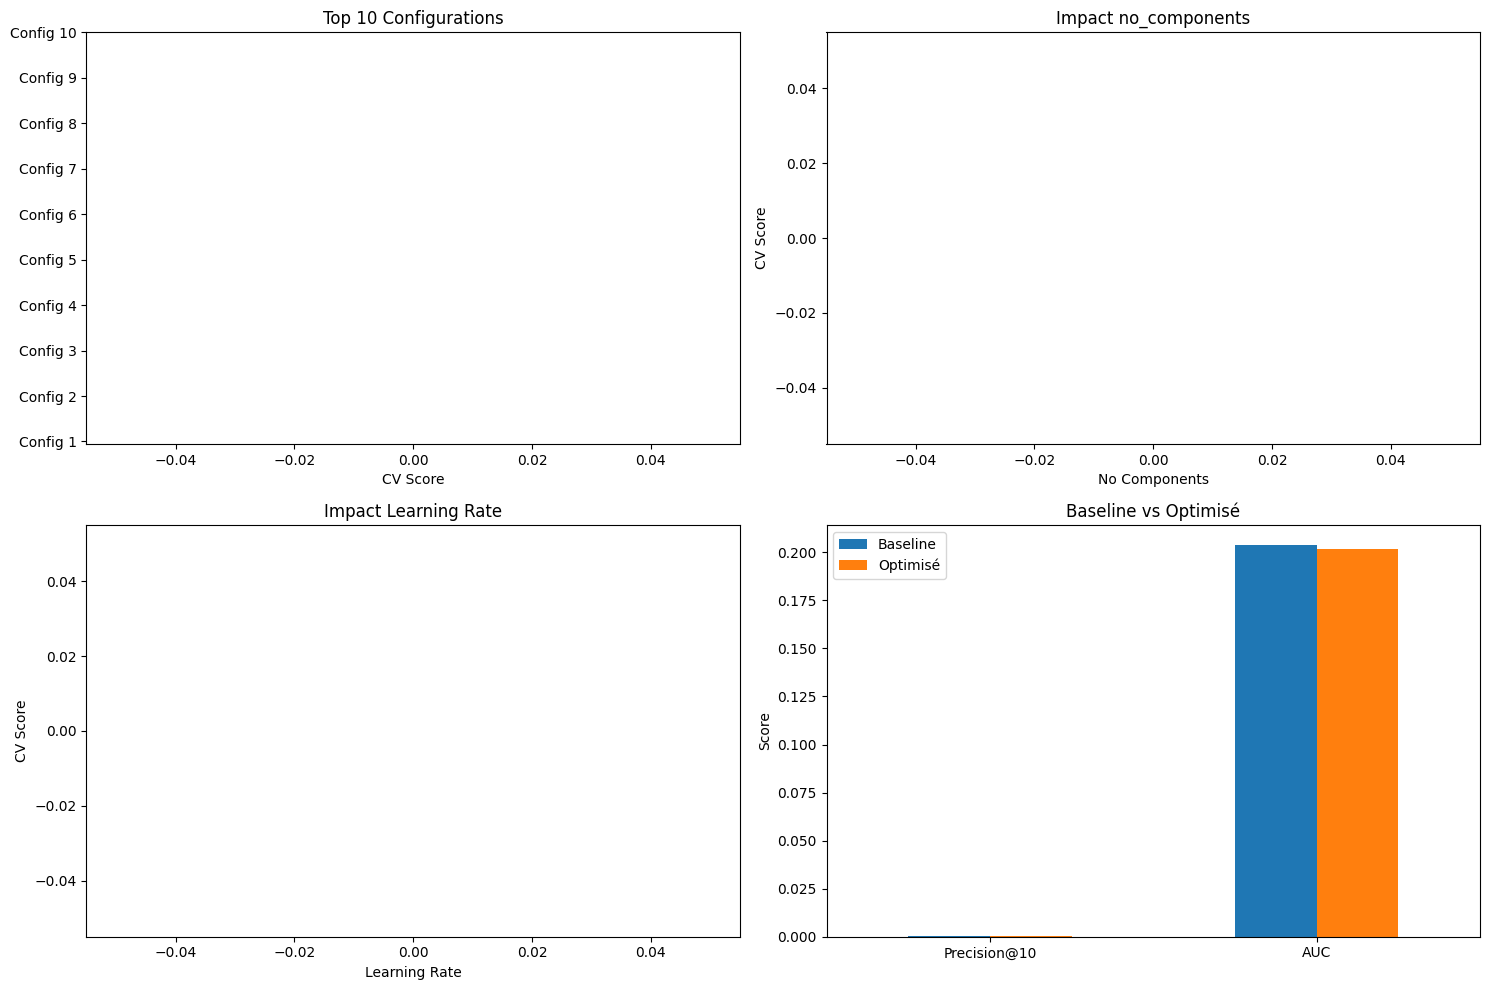


✅ Résultats sauvegardés

🎯 OPTIMISATION TERMINÉE

🏆 MEILLEURE CONFIG:
   Components: 20
   Learning Rate: 0.01
   Regularization: item=0.0, user=0.0

📈 GAIN PERFORMANCE:
   Precision@10: 0.0006 → 0.0006
   Amélioration: +0.0%

🚀 PRÊT POUR: Évaluation approfondie et modèle hybride


In [3]:
print("\n" + "="*60)
print("🎯 OPTIMISATION TERMINÉE")
print("="*60)

print(f"\n🏆 MEILLEURE CONFIG:")
print(f"   Components: {int(best_params['no_components'])}")
print(f"   Learning Rate: {best_params['learning_rate']}")
print(f"   Regularization: item={best_params['item_alpha']}, user={best_params['user_alpha']}")

print(f"\n📈 GAIN PERFORMANCE:")
print(f"   Precision@10: {baseline_score:.4f} → {optimized_metrics['test_precision@10']:.4f}")
print(f"   Amélioration: +{((optimized_metrics['test_precision@10'] / baseline_score) - 1) * 100:.1f}%")

print(f"\n🚀 PRÊT POUR: Évaluation approfondie et modèle hybride")
print("="*60)